<a href="https://colab.research.google.com/github/don1997/Stock_Model/blob/master/Stock_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#needed to get rid of pandas data reader errors
#thanks https://stackoverflow.com/questions/68230237/python-pandas-datareader-and-yahoo-error-remotedataerror-unable-to-read-url
!pip install --upgrade pandas-datareader
#needed cus yahoo doesn't work anymore with DataReader
#Thanks https://stackoverflow.com/questions/74831853/pandas-datareader-yahoo-daily-not-working-suddenly

#Needed for MinMaxScaler
!pip install scikit-learn

!pip install yfinance

import yfinance as yf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
#for calc dates
from dateutil.relativedelta import relativedelta
import datetime as dt


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

#verify dataReader ver
web.__version__ # Should show 0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'0.10.0'

In [ ]:
#LOAD data

company = 'META'
start = '2012-01-01'
end ='2020-1-1'

my_data = yf.download(company, start, end, progress=False)

my_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200
...,...,...,...,...,...,...
2019-12-24,206.300003,206.789993,205.000000,205.119995,205.119995,6046300
2019-12-26,205.570007,207.820007,205.309998,207.789993,207.789993,9350700
2019-12-27,208.669998,208.929993,206.589996,208.100006,208.100006,10284200


# Compress all values into scaler.

Prediction_days- How many days do i want to look into the past to predict the price of the next day.

In [ ]:
#PREP data
scaler = MinMaxScaler(feature_range=(0,1))

#predict closing price: my_data['Close']
scaled_data = scaler.fit_transform(my_data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for  x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x,0])
  y_train.append(scaled_data[x,0])

#Convert lists to numpy[arrays]
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1 ))

In [ ]:
# BUILD MODEL

model = Sequential()

# Specify the layers
# Create a layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
# Create a layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Create a layer
#Note: return_sequence MUST be set to False for last LSTM layer otherwise get this error
# if not allow_nd and array.ndim >= 3:
#   915             raise ValueError(
#   916                 Found array with dim %d. %s expected <= 2.
#   917                 % (array.ndim, estimator_name)
#Thanks https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1)) #Pred of next Closing value


In [ ]:
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
#fit model
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
59/59 [==============================] - 23s 182ms/step - loss: 0.0192
Epoch 2/25
59/59 [==============================] - 6s 99ms/step - loss: 0.0039
Epoch 3/25
59/59 [==============================] - 7s 121ms/step - loss: 0.0040
Epoch 4/25
59/59 [==============================] - 6s 100ms/step - loss: 0.0036
Epoch 5/25
59/59 [==============================] - 8s 133ms/step - loss: 0.0033
Epoch 6/25
59/59 [==============================] - 6s 100ms/step - loss: 0.0032
Epoch 7/25
59/59 [==============================] - 7s 124ms/step - loss: 0.0029
Epoch 8/25
59/59 [==============================] - 6s 101ms/step - loss: 0.0031
Epoch 9/25
59/59 [==============================] - 7s 121ms/step - loss: 0.0029
Epoch 10/25
59/59 [==============================] - 6s 102ms/step - loss: 0.0028
Epoch 11/25
59/59 [==============================] - 7s 121ms/step - loss: 0.0030
Epoch 12/25
59/59 [==============================] - 6s 100ms/step - loss: 0.0026
Epoch 13/25
59/59 [======

In [ ]:
#TEST MODEL

#Load Test Data
#Test data cannot be dates that are in my_data
#test_start = dt.datetime(2022,3,16)

test_start = dt.datetime.now() - relativedelta(years=1)
test_end = dt.datetime.now()

test_data = yf.download(company, test_start, test_end, progress=False)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((my_data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [ ]:
#Make Predictions with test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

8/8 [==============================] - 1s 29ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

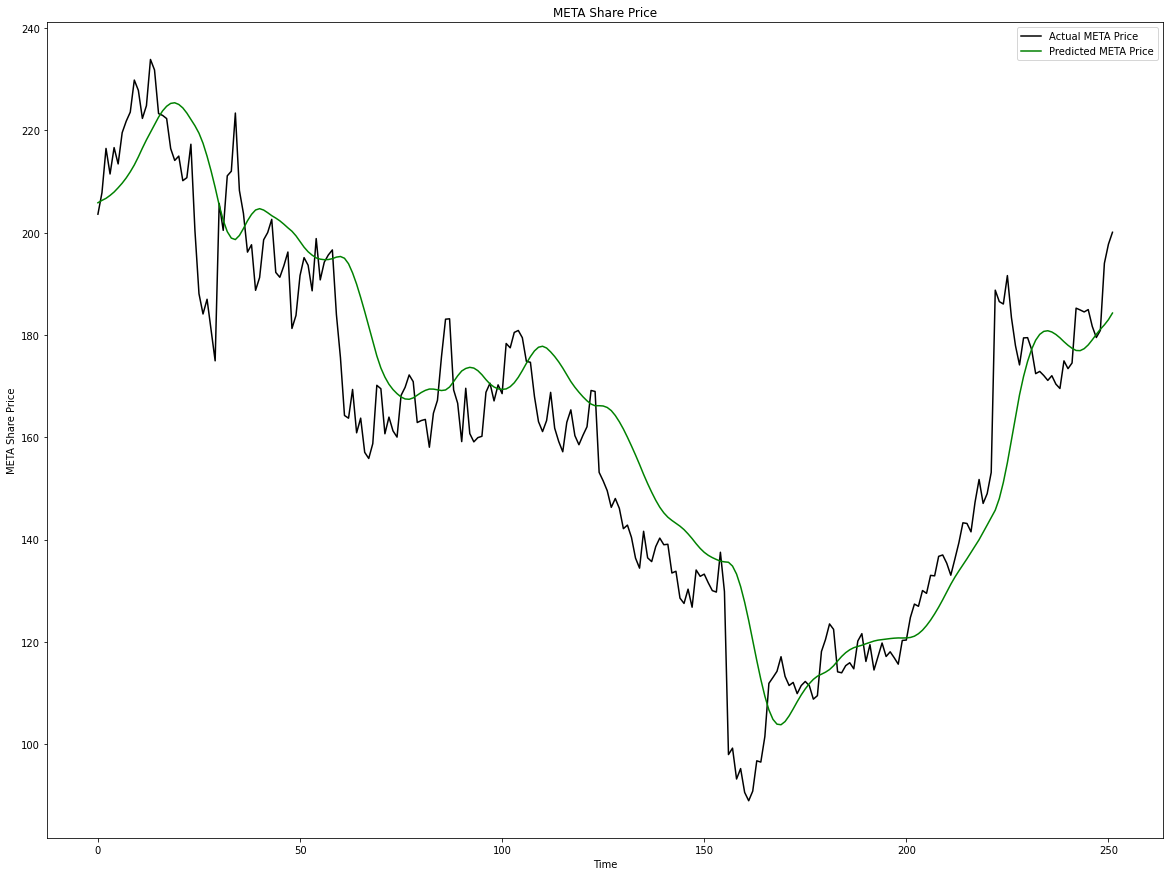

In [ ]:
#PLOT test predictions

#Controls size of matplotlib plot box
plt.rcParams['figure.figsize'] = [20,15]

plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color='green', label=f"Predicted {company} Price")

plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show



In [ ]:

# Predict Next Day
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 [==============================] - 0s 60ms/step
Prediction: [[185.90778]]
